# Exercise 1: Bank Marketing Data
Use the bank direct marketing dataset to train a logistic regression (scikit-learn) predicting if a client will subscribe (1 or 0) to a term deposit (variable called ‘y’).

Create a ML pipeline taking in account the following points:
- Use class_weight = ‘balanced’, as the dataset is unbalanced

- Use a train and test setup

- Use k-fold cross-validation to choose between L1- and L2-penalty or no penalty (you will have to specify ‘penalty’ and ‘C’, logistic regression documentation)

- Test the effect of penalty for a sample of only 1000 data points.

- Evaluate the effect of adding more data points. What happens and why?

- Once you have chosen the best model (best test score), plot the ROC curve as well as precision and recall with varying thresholds (use the precision_recall_curve function from sklearn).

In [1]:
import matplotlib.pyplot as plt
plt.rc("font", size=14)
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", 
        color_codes=True, 
        font_scale = 2)
import numpy as np
import pandas as pd
import os
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score 
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.utils import shuffle

In [2]:
os.chdir('/Users/patrickrs/Documents/GitLab/patrick-steiner/03-Machine-Learning')

In [3]:
banking = pd.read_csv("banking.csv")
hold = 0.1

In [4]:
# Grouping basic education together
banking['education'] = np.where(banking['education'] == 'basic.9y', 'Basic', banking['education'])
banking['education'] = np.where(banking['education'] == 'basic.6y', 'Basic', banking['education'])
banking['education'] = np.where(banking['education'] == 'basic.4y', 'Basic', banking['education'])

In [5]:
banking.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,44,blue-collar,married,Basic,unknown,yes,no,cellular,aug,thu,...,1,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1,0
1,53,technician,married,unknown,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.021,5195.8,0
2,28,management,single,university.degree,no,yes,no,cellular,jun,thu,...,3,6,2,success,-1.7,94.055,-39.8,0.729,4991.6,1
3,39,services,married,high.school,no,no,no,cellular,apr,fri,...,2,999,0,nonexistent,-1.8,93.075,-47.1,1.405,5099.1,0
4,55,retired,married,Basic,no,yes,no,cellular,aug,fri,...,1,3,1,success,-2.9,92.201,-31.4,0.869,5076.2,1


In [6]:
# Creating dummmies for categorical vars
cat_vars=['job','marital','education','default','housing','loan','contact','month','day_of_week','poutcome']
for var in cat_vars:
    banking[var] = banking[var].astype('category') # similar to R's factor.

In [7]:
# Let's see if this neat trick worked:
banking['job'].cat.codes
banking['job'].cat.categories

Index(['admin.', 'blue-collar', 'entrepreneur', 'housemaid', 'management',
       'retired', 'self-employed', 'services', 'student', 'technician',
       'unemployed', 'unknown'],
      dtype='object')

In [8]:
# Excellent! (I later found out that this does not work. Imagine the disappointment.)

In [9]:
y = banking['y']
X = banking.drop('y', 
                 axis = 'columns')

In [22]:
# Let's look at our dist:
y.value_counts()
#sns.countplot(x = y,
#             palette = 'dark')

0    36548
1     4640
Name: y, dtype: int64

In [11]:
banking.dtypes

age                  int64
job               category
marital           category
education         category
default           category
housing           category
loan              category
contact           category
month             category
day_of_week       category
duration             int64
campaign             int64
pdays                int64
previous             int64
poutcome          category
emp_var_rate       float64
cons_price_idx     float64
cons_conf_idx      float64
euribor3m          float64
nr_employed        float64
y                    int64
dtype: object

In [12]:
# strategy 'constant' simply means filling with the fill_value
categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
                                          ('onehot', OneHotEncoder(handle_unknown='ignore'))
                                         ]
                                  )
# filling missing values with median and scaling
numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                                      ('scaler', StandardScaler())
                                     ]
                              )         

In [13]:
# Next we use the ColumnTransformer to apply the transformations to the correct columns in the dataframe
num_vars = X.select_dtypes(include=['int64', 'float64']).columns # numeric vars
cat_vars = cat_vars # from previous attempt

preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, num_vars),
                                               ('cat', categorical_transformer, cat_vars)
                                              ]
                                )

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=hold, random_state=1)

model = LogisticRegression(max_iter = 1000,
                           class_weight = 'balanced' # balances weight of zeros and ones in y
                          )
logit = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', model)
                       ]
                )

logit.fit(X_train,y_train)
predictions = logit.predict(X_test)
model_score = logit.score(X_test, y_test)
model_score

0.8679291090070406

#### Use k-fold cross-validation to choose between L1- and L2-penalty or no penalty (you will have to specify ‘penalty’ and ‘C’, logistic regression documentation)

In [17]:
alphas = np.logspace(start = .1, stop = 5, num = 50)

In [18]:
alphas

array([1.25892541e+00, 1.58489319e+00, 1.99526231e+00, 2.51188643e+00,
       3.16227766e+00, 3.98107171e+00, 5.01187234e+00, 6.30957344e+00,
       7.94328235e+00, 1.00000000e+01, 1.25892541e+01, 1.58489319e+01,
       1.99526231e+01, 2.51188643e+01, 3.16227766e+01, 3.98107171e+01,
       5.01187234e+01, 6.30957344e+01, 7.94328235e+01, 1.00000000e+02,
       1.25892541e+02, 1.58489319e+02, 1.99526231e+02, 2.51188643e+02,
       3.16227766e+02, 3.98107171e+02, 5.01187234e+02, 6.30957344e+02,
       7.94328235e+02, 1.00000000e+03, 1.25892541e+03, 1.58489319e+03,
       1.99526231e+03, 2.51188643e+03, 3.16227766e+03, 3.98107171e+03,
       5.01187234e+03, 6.30957344e+03, 7.94328235e+03, 1.00000000e+04,
       1.25892541e+04, 1.58489319e+04, 1.99526231e+04, 2.51188643e+04,
       3.16227766e+04, 3.98107171e+04, 5.01187234e+04, 6.30957344e+04,
       7.94328235e+04, 1.00000000e+05])

In [19]:
# L2 score:
k = 10
l2scores = np.empty(shape=0)

for alpha in alphas:

    model = LogisticRegression(max_iter = 1000,
                               class_weight = 'balanced', # balances weight of zeros and ones in y
                               penalty = 'l2',
                               solver = 'lbfgs',
                               C = alpha
                              )
    logit = Pipeline(steps=[('preprocessor', preprocessor),
                            ('classifier', model)
                           ])

    scores_temp = cross_val_score(logit, 
                                  X, 
                                  y, 
                                  cv = k
                                 )
    l2scores = np.append(l2scores, np.mean(scores_temp))


In [20]:
# L1 score
l1scores = np.empty(shape=0)
for alpha in alphas:

    model = LogisticRegression(max_iter = 10000,
                               class_weight = 'balanced', # balances weight of zeros and ones in y
                               penalty = 'l1',
                               solver = 'saga',
                               C = alpha
                              )
    logit = Pipeline(steps=[('preprocessor', preprocessor),
                            ('classifier', model)
                           ])

    scores_temp = cross_val_score(logit, 
                                  X, 
                                  y, 
                                  cv = k
                                 )
    l1scores = np.append(l1scores, np.mean(scores_temp))

(array([19.,  0.,  0.,  0.,  2., 27.,  0.,  0.,  0.,  2.]),
 array([0.86054208, 0.86054694, 0.86055179, 0.86055665, 0.8605615 ,
        0.86056636, 0.86057121, 0.86057607, 0.86058092, 0.86058578,
        0.86059064]),
 <a list of 10 Patch objects>)

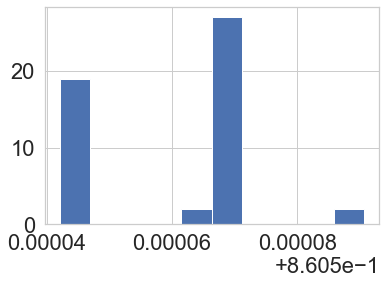

In [35]:
#fig = plt.figure()
#ax1 = fig.add_subplot(211)
#ax1.set_title('Scores for Different Alphas')
#ax1.set_ylabel('Alpha')
#ax1.set_xlabel('Mean Accuracy')
#plt.yscale("log")
#plt.scatter(l2scores, alphas, color = 'red')
#plt.scatter(l1scores, alphas, color = 'blue')
#plt.legend()
plt.hist(l1scores)

array([0.85])

### Test the effect of penalty for a sample of only 1000 data points.

In [141]:
sizes = range(start = 1000, stop = len(y), step = 1000) 
banking_shuffled = shuffle(banking)# imported from sklearn


In [149]:
# L2 score:
k = 10

alphas = np.logspace(start = .1, stop = 5, num = 50)
l2scores = np.empty(shape=0)

for size in sizes:

    y = banking_shuffled['y'].head(size)
    X = banking_shuffled.drop('y', axis = 'columns').head(size)

    model = LogisticRegression(max_iter = 1000,
                               class_weight = 'balanced', # balances weight of zeros and ones in y
                               penalty = 'l2',
                               solver = 'lbfgs',
                               C = alpha
                              )
    logit = Pipeline(steps=[('preprocessor', preprocessor),
                            ('classifier', model)
                           ]
                    )

    scores_temp = cross_val_score(logit, 
                                  X, 
                                  y, 
                                  cv = k
                                 )
    l2scores = np.append(l2scores, np.mean(scores_temp))


In [150]:
# L1 score
l1scores = np.empty(shape=0)
for alpha in alphas:

    model = LogisticRegression(max_iter = 10000,
                               class_weight = 'balanced', # balances weight of zeros and ones in y
                               penalty = 'l1',
                               solver = 'saga',
                               C = alpha
                              )
    logit = Pipeline(steps=[('preprocessor', preprocessor),
                            ('classifier', model)
                           ])

    scores_temp = cross_val_score(logit, 
                                  X, 
                                  y, 
                                  cv = k
                                 )
    l1scores = np.append(l1scores, np.mean(scores_temp))

In [151]:
print("L1 Score: ", meanl1)
print("L2 Score: ", meanl2)

L1 Score:  0.86
L2 Score:  0.86


Doesn't make a difference in scores.